In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
df = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv')

In [2]:
df.columns = df.columns.str.replace('\n', ' ')
df.drop(['Unnamed: 13'], axis=1, inplace=True)
df.columns

Index(['City', 'Population', 'Violent crime',
       'Murder and nonnegligent manslaughter', 'Rape (revised definition)1',
       'Rape (legacy definition)2', 'Robbery', 'Aggravated assault',
       'Property crime', 'Burglary', 'Larceny- theft', 'Motor vehicle theft',
       'Arson3'],
      dtype='object')

In [3]:
fix = ['Population', 'Violent crime', 'Rape (legacy definition)2', 'Robbery', 'Aggravated assault', 
       'Property crime', 'Burglary', 'Larceny- theft', 'Motor vehicle theft']
for key in fix:
    df[key] = pd.to_numeric(df[key].astype(str).str.replace(',',''), errors='ignore')

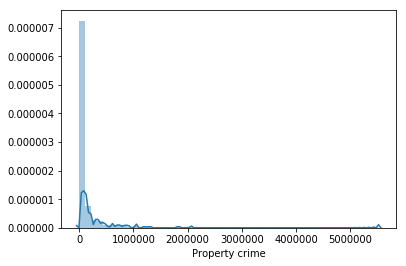

In [16]:
for key in fix:
    df[key] = pd.to_numeric(df[key].astype(str).str.replace(',',''), errors='coerce')
df.dropna(axis=1, how='all', inplace=True)
df.dropna(axis=0, how='all', inplace=True)
#Use to make sure all the values are now numerical
#df.dtypes
sns.distplot(df['Property crime'])

In [5]:
#detecting outliers
display(df.loc[df['Property crime']>5000, :])
df.drop(df[df['Property crime']>5000].index, inplace=True)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
35,Buffalo,258789.000,3249.000,47.000,145.000,1322.000,1735.000,12491.000,3458.000,8076.000,957.000,nan
216,New York,8396126.000,52384.000,335.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,nan
272,Rochester,210562.000,2107.000,42.000,92.000,918.000,1055.000,10051.000,2587.000,6855.000,609.000,132.000
310,Syracuse,143834.000,1192.000,21.000,75.000,400.000,696.000,6473.000,1781.000,4298.000,394.000,57.000


In [6]:
df['Arson3'].fillna(0, inplace=True)
df['Population^2'] = df['Population'].map(lambda x: x**2)
df['Murder'] = np.where(df['Murder and nonnegligent manslaughter']>0, 1, 0)
df['Robbery_feature'] = np.where(df['Robbery']>0, 1, 0)
df['Arson_data'] = np.where(df['Arson3']>0, 1, 0)
df['Motor_theft'] = np.where(df['Motor vehicle theft']>0, 1, 0)
df['Burg_bool'] = np.where(df['Burglary']>0, 1,0)

In [7]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['Property crime'].values.reshape(-1, 1)
X = df[['Population^2', 'Murder', 'Robbery_feature', 'Arson_data', 'Motor_theft', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[3.28991017e-08 4.28090605e+00 9.20913363e+01 1.73350040e+01
  3.63727340e+01 4.11320365e+00]]

Intercept: 
 [-5.79728854]

R-squared:
0.8855739613297764


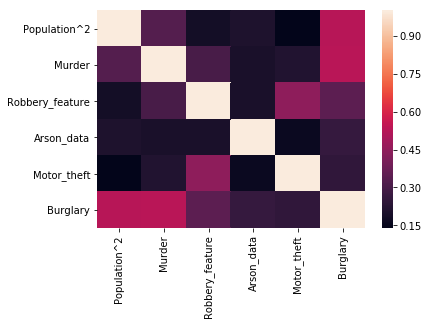

In [8]:
sns.heatmap(X.corr())

# Multivariate normality check

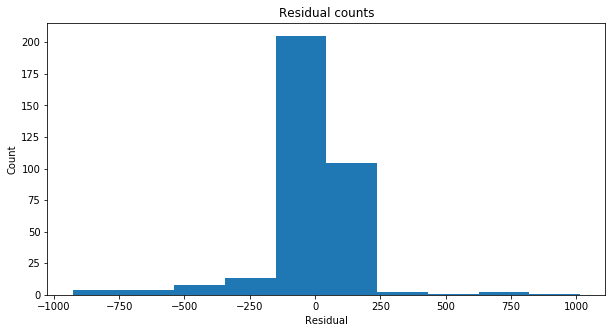

In [9]:
actual = df['Property crime']
predicted = regr.predict(X).ravel()
residual = predicted-actual

plt.figure(figsize=(10,5))
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [10]:
display(df.loc[np.abs(residual)>250])
df.drop(df[np.abs(residual)>250].index, inplace=True)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Population^2,Murder,Robbery_feature,Arson_data,Motor_theft,Burg_bool
3,Albany,97956.000,791.000,8.000,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,0.000,9595377936.000,1,1,0,1,1
7,Amherst Town,118296.000,107.000,1.000,7.000,31.000,68.000,2118.000,204.000,1882.000,32.000,3.000,13993943616.000,1,1,1,1,1
53,Cheektowaga Town,78361.000,158.000,0.000,11.000,48.000,99.000,2689.000,345.000,2271.000,73.000,2.000,6140446321.000,0,1,1,1,1
57,Clarkstown Town,80705.000,65.000,0.000,8.000,17.000,40.000,1515.000,99.000,1388.000,28.000,0.000,6513297025.000,0,1,0,1,1
62,Colonie Town,78215.000,63.000,0.000,0.000,31.000,32.000,1990.000,186.000,1753.000,51.000,10.000,6117586225.000,0,1,1,1,1
112,Gates Town,28468.000,57.000,0.000,4.000,19.000,34.000,1051.000,95.000,922.000,34.000,0.000,810427024.000,0,1,0,1,1
126,Greece Town,96667.000,151.000,0.000,9.000,60.000,82.000,2303.000,332.000,1925.000,46.000,0.000,9344508889.000,0,1,0,1,1
133,Guilderland Town,33805.000,12.000,0.000,3.000,5.000,4.000,672.000,48.000,623.000,1.000,0.000,1142778025.000,0,1,0,1,1
134,Hamburg Town,45535.000,38.000,1.000,1.000,12.000,24.000,1167.000,134.000,1012.000,21.000,6.000,2073436225.000,1,1,1,1,1
155,Johnson City Village,14866.000,69.000,1.000,6.000,20.000,42.000,949.000,111.000,828.000,10.000,0.000,220997956.000,1,1,0,1,1


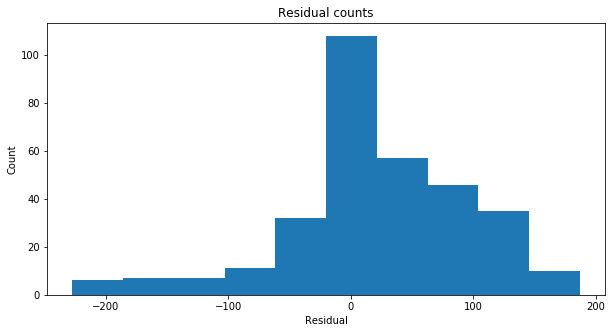

In [11]:
actual = df['Property crime']
X = df[['Population^2', 'Murder', 'Robbery_feature', 'Arson_data', 'Motor_theft', 'Burglary']]
predicted = regr.predict(X).ravel()
residual = predicted-actual

plt.figure(figsize=(10,5))
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Homoscadasticity check

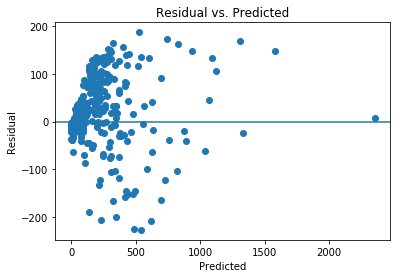

In [12]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [14]:
df['Property crime'] = df['Property crime'].map(lambda x: x**2)

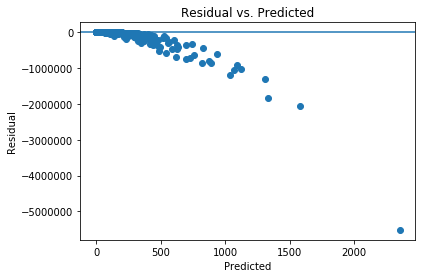

In [15]:
actual = df['Property crime']
X = df[['Population^2', 'Murder', 'Robbery_feature', 'Arson_data', 'Motor_theft', 'Burglary']]
predicted = regr.predict(X).ravel()
residual = predicted-actual

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

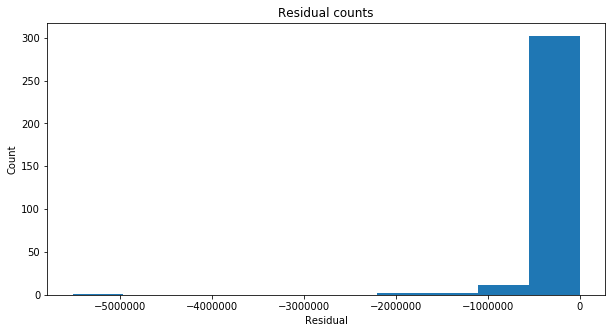

In [17]:
plt.figure(figsize=(10,5))
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()